# Designing a Recommender System to alleivate mental health problems by studying different music genres


The purpose of the notebook is to study different user attributes like age , type of mental health challenges like anxiety, depression, insomnia or OCD that the user is undergoing and recommend the suitable music genre based on its likeability. The notebook has been taken from https://github.com/tanyakuznetsova/Music_Mental_Health/blob/main/Rec_system_Music_Mental_Health.ipynb

In [1]:
from google.colab import drive
import sys
drive.mount('/content/drive')
%cd "/content/drive/My Drive/Colab Notebooks/mental-health-codes"
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/mental-health-codes')

%reload_ext autoreload
%autoreload 2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/mental-health-codes


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, classification_report
from sklearn import preprocessing

In [3]:
data = pd.read_csv('mxmh_survey_results.csv')

In [4]:
data.shape

(736, 33)

In [5]:
data.columns

Index(['Timestamp', 'Age', 'Primary streaming service', 'Hours per day',
       'While working', 'Instrumentalist', 'Composer', 'Fav genre',
       'Exploratory', 'Foreign languages', 'BPM', 'Frequency [Classical]',
       'Frequency [Country]', 'Frequency [EDM]', 'Frequency [Folk]',
       'Frequency [Gospel]', 'Frequency [Hip hop]', 'Frequency [Jazz]',
       'Frequency [K pop]', 'Frequency [Latin]', 'Frequency [Lofi]',
       'Frequency [Metal]', 'Frequency [Pop]', 'Frequency [R&B]',
       'Frequency [Rap]', 'Frequency [Rock]', 'Frequency [Video game music]',
       'Anxiety', 'Depression', 'Insomnia', 'OCD', 'Music effects',
       'Permissions'],
      dtype='object')

In [6]:
data["Music effects"].unique() #labels

array([nan, 'No effect', 'Improve', 'Worsen'], dtype=object)

In [7]:
data.isnull().values.any()

True

# Data Cleaning

Drop NULL or replace?
*   Looks like dropping nulls will suffice. Compared to the amount of data entries, dropping shouldn't be a concern here [except BPM]

Dropping columns?

*   BPM is not a column we are intending to use, so we can drop. (it also has the most nulls)
* Perhaps drop Timestamp as well? Not sure how necessary it is for us.



In [8]:
#See nulls across the dataset
data.isna().sum()

,0
Timestamp,0
Age,1
Primary streaming service,1
Hours per day,0
While working,3
Instrumentalist,4
Composer,1
Fav genre,0
Exploratory,0
Foreign languages,4


In [9]:
#Drop nulls
clean_data = data.dropna()

In [10]:
len(clean_data)

616

In [11]:
#verify nulls are gone
clean_data.isna().sum()

,0
Timestamp,0
Age,0
Primary streaming service,0
Hours per day,0
While working,0
Instrumentalist,0
Composer,0
Fav genre,0
Exploratory,0
Foreign languages,0


In [12]:
#drop unneccsary columns
clean_data = clean_data.drop(columns=['Timestamp', 'Composer','BPM','Permissions'])

In [13]:
#verify columns are dropped
clean_data.head(2)

,Age,Primary streaming service,Hours per day,While working,Instrumentalist,Fav genre,Exploratory,Foreign languages,Frequency [Classical],Frequency [Country],...,Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,Music effects
2,18.0,Spotify,4.0,No,No,Video game music,No,Yes,Never,Never,...,Rarely,Never,Rarely,Rarely,Very frequently,7.0,7.0,10.0,2.0,No effect
3,61.0,YouTube Music,2.5,Yes,No,Jazz,Yes,Yes,Sometimes,Never,...,Sometimes,Sometimes,Never,Never,Never,9.0,7.0,3.0,3.0,Improve


In [14]:
# Encode our categorical variables into numeric values

encoded_data = pd.DataFrame()

encoder = preprocessing.LabelEncoder()

for column in clean_data.select_dtypes(include='object'):
    encoded_data[column] = encoder.fit_transform(clean_data[column])

encoded_data.head()


,Primary streaming service,While working,Instrumentalist,Fav genre,Exploratory,Foreign languages,Frequency [Classical],Frequency [Country],Frequency [EDM],Frequency [Folk],...,Frequency [K pop],Frequency [Latin],Frequency [Lofi],Frequency [Metal],Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Music effects
0,4,0,0,15,0,1,0,0,3,0,...,3,0,2,2,1,0,1,1,3,1
1,5,1,0,6,1,1,2,0,0,1,...,2,3,2,0,2,2,0,0,0,0
2,4,1,0,12,1,0,0,0,1,0,...,3,2,2,0,2,3,3,0,1,0
3,4,1,1,6,1,1,1,2,0,0,...,3,1,3,1,3,3,3,3,0,0
4,5,1,1,15,1,1,2,0,1,2,...,0,1,1,1,1,1,0,0,2,0


In [15]:
clean_data.head()

,Age,Primary streaming service,Hours per day,While working,Instrumentalist,Fav genre,Exploratory,Foreign languages,Frequency [Classical],Frequency [Country],...,Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,Music effects
2,18.0,Spotify,4.0,No,No,Video game music,No,Yes,Never,Never,...,Rarely,Never,Rarely,Rarely,Very frequently,7.0,7.0,10.0,2.0,No effect
3,61.0,YouTube Music,2.5,Yes,No,Jazz,Yes,Yes,Sometimes,Never,...,Sometimes,Sometimes,Never,Never,Never,9.0,7.0,3.0,3.0,Improve
4,18.0,Spotify,4.0,Yes,No,R&B,Yes,No,Never,Never,...,Sometimes,Very frequently,Very frequently,Never,Rarely,7.0,2.0,5.0,9.0,Improve
5,18.0,Spotify,5.0,Yes,Yes,Jazz,Yes,Yes,Rarely,Sometimes,...,Very frequently,Very frequently,Very frequently,Very frequently,Never,8.0,8.0,7.0,7.0,Improve
6,18.0,YouTube Music,3.0,Yes,Yes,Video game music,Yes,Yes,Sometimes,Never,...,Rarely,Rarely,Never,Never,Sometimes,4.0,8.0,6.0,0.0,Improve


In [16]:
print(f'Validate both datasets are consistent post encoder. \nClean dataset: {len(clean_data)} \nEncoded Dataset: {len(encoded_data)}')

Validate both datasets are consistent post encoder. 
Clean dataset: 616 
Encoded Dataset: 616


In [17]:
#looks at max value of each column (i.e. 0-15) to make sure all categorical variables have been accounted for to their numerical counterpart
encoded_data.max(axis=0)

,0
Primary streaming service,5
While working,1
Instrumentalist,1
Fav genre,15
Exploratory,1
Foreign languages,1
Frequency [Classical],3
Frequency [Country],3
Frequency [EDM],3
Frequency [Folk],3


Docs For Recomender System Reference:
* YT Video: https://www.youtube.com/watch?v=G4MBc40rQ2k
* Geeksforgeeks(high level w/ implementation): https://www.geeksforgeeks.org/recommendation-system-in-python/
* Movie rec system: https://thecleverprogrammer.com/2020/05/20/data-science-project-movie-recommendation-system/
* high lvl implementation: https://365datascience.com/tutorials/how-to-build-recommendation-system-in-python/


# Collaborative Filtering Recommender Systems

*The following goal of the collaborative filtering recommender system is to predict a positive outcome (an improvement) in mental health.*

To accomplish this, we engineer 'implicit' ratings from listeners based on how often they listen to a particular genre. (e.g. listening to Classical music 'Very Freqeuntly' is given a high rating (3) and listening to Hip Hop music 'Never' is given a rating of 0

*recommended path forward:*
1. Create a sub df with all entries that have a positive music effect.
2. Drop everything excep frequencies.
3. Implement a Rec System

In [18]:
# 3. Implement a Rec System
%pip install scikit-surprise -q

In [19]:
encoded_data.head(2)

,Primary streaming service,While working,Instrumentalist,Fav genre,Exploratory,Foreign languages,Frequency [Classical],Frequency [Country],Frequency [EDM],Frequency [Folk],...,Frequency [K pop],Frequency [Latin],Frequency [Lofi],Frequency [Metal],Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Music effects
0,4,0,0,15,0,1,0,0,3,0,...,3,0,2,2,1,0,1,1,3,1
1,5,1,0,6,1,1,2,0,0,1,...,2,3,2,0,2,2,0,0,0,0


In [20]:
#1. Create a sub df with all entries that have a positive music effect.
improved_df = encoded_data[encoded_data['Music effects'] == 1]

In [21]:
#validate 1
improved_df[improved_df['Music effects'] != 1]

,Primary streaming service,While working,Instrumentalist,Fav genre,Exploratory,Foreign languages,Frequency [Classical],Frequency [Country],Frequency [EDM],Frequency [Folk],...,Frequency [K pop],Frequency [Latin],Frequency [Lofi],Frequency [Metal],Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Music effects


In [22]:
# create list of tuples[(uid, iid, rate)]
def vectorize(user_id, row):
  new_row = row.drop(labels=['Primary streaming service', 'While working','Instrumentalist','Fav genre','Exploratory','Foreign languages','Music effects'], axis=0)
  ratings = []
  for music,rating in new_row.items():
    ratings.append((user_id, music, rating))

  return ratings


In [23]:
user_ratings = []

for user, row in improved_df.iterrows():
  user_ratings += vectorize(user, row)

In [24]:
#list --> df for rec system input
user_ratings_df = pd.DataFrame(user_ratings)

In [25]:
user_ratings_df.head(20)

,0,1,2
0,0,Frequency [Classical],0
1,0,Frequency [Country],0
2,0,Frequency [EDM],3
3,0,Frequency [Folk],0
4,0,Frequency [Gospel],0
5,0,Frequency [Hip hop],1
6,0,Frequency [Jazz],1
7,0,Frequency [K pop],3
8,0,Frequency [Latin],0
9,0,Frequency [Lofi],2


In [26]:
#Performance Check Pt1 of Rec System
from surprise import Dataset, Reader, SVD, KNNBasic
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise import accuracy
import random
from surprise.model_selection import GridSearchCV


#Load Dataset
reader = Reader(rating_scale=(0, 3))
data = Dataset.load_from_df(user_ratings_df,reader)
raw_ratings = data.raw_ratings

# shuffle ratings if you want
random.shuffle(raw_ratings)

# 90% trainset, 10% testset
threshold = int(.9 * len(raw_ratings))
trainset_raw_ratings = raw_ratings[:threshold]
test_raw_ratings = raw_ratings[threshold:]

data.raw_ratings = trainset_raw_ratings  # data is now your trainset
#data.split(n_folds=3)

#trainset = data.build_full_trainset()
# trainset = data.construct_trainset()
# testset = data.construct_testset()

# Select & Train Model
sim_options = {
     "name": "pearson",
}
model = KNNBasic(sim_options=sim_options)
# retrain on the whole train set
trainset = data.build_full_trainset()
model.fit(trainset)
cross_validate(model, data, measures=["RMSE", "MAE"], cv=5, verbose=True)

# now test on the trainset
testset = data.construct_testset(trainset_raw_ratings)
predictions = model.test(testset)
print('Accuracy on the trainset:')
accuracy.rmse(predictions)
accuracy.mae(predictions)
accuracy.mse(predictions)
accuracy.fcp(predictions)

# now test on the testset
testset = data.construct_testset(test_raw_ratings)
predictions = model.test(testset)
print('Accuracy on the testset:')
accuracy.rmse(predictions)
accuracy.mae(predictions)
accuracy.mse(predictions)
accuracy.fcp(predictions)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9557  0.9504  0.9246  0.9768  0.9175  0.9450  0.0216  
MAE (testset)     0.8012  0.7865  0.7535  0.8185  0.7640  0.7847  0.0237  
Fit time          0.01    0.01    0.01    0.02    0.01    0.01    0.01    
Test time         0.08    0.13    0.10    0.21    0.33    0.17    0.09    
Accuracy on the trainset:
RMSE: 0.7315
MAE:  0.6021
MSE: 0.5351
FCP:  0.8898
Accuracy on the testset:
RM

0.6153846153846154

In [27]:
#Predictions - re-train on unseen user
from surprise.accuracy import rmse
sad_df = encoded_data[encoded_data['Music effects'] == 0]

all_items = user_ratings_df[1].unique()
print(all_items)

predictions=[]

for user_id, row in sad_df.iterrows():
  sad_boi_raw = vectorize(user_id, row)
  user_included_df = pd.DataFrame(user_ratings + sad_boi_raw)

  data = Dataset.load_from_df(user_included_df,reader)
  trainset = data.build_full_trainset()
  model.fit(trainset)

  # Predict ratings for unrated items
  for iid in all_items:
    pred = model.predict(user_id, iid )
    print(pred)
    predictions.append([user_id, iid, pred.est])


Streaming output truncated to the last 5000 lines.
user: 248        item: Frequency [EDM] r_ui = None   est = 0.54   {'actual_k': 40, 'was_impossible': False}
user: 248        item: Frequency [Folk] r_ui = None   est = 1.61   {'actual_k': 40, 'was_impossible': False}
user: 248        item: Frequency [Gospel] r_ui = None   est = 0.28   {'actual_k': 40, 'was_impossible': False}
user: 248        item: Frequency [Hip hop] r_ui = None   est = 1.26   {'actual_k': 40, 'was_impossible': False}
user: 248        item: Frequency [Jazz] r_ui = None   est = 1.20   {'actual_k': 40, 'was_impossible': False}
user: 248        item: Frequency [K pop] r_ui = None   est = 0.21   {'actual_k': 40, 'was_impossible': False}
user: 248        item: Frequency [Latin] r_ui = None   est = 0.94   {'actual_k': 40, 'was_impossible': False}
user: 248        item: Frequency [Lofi] r_ui = None   est = 0.50   {'actual_k': 40, 'was_impossible': False}
user: 248        item: Frequency [Metal] r_ui = None   est = 1.08   {'a

In [28]:
recommender_output_dataframe = pd.DataFrame(predictions, columns=["user_id","genre", "score"])
recommender_output_dataframe.head()

,user_id,genre,score
0,1,Frequency [Classical],2.161321
1,1,Frequency [Country],0.350627
2,1,Frequency [EDM],0.618204
3,1,Frequency [Folk],0.872143
4,1,Frequency [Gospel],0.685762


##Finding Top Recommended items based on rating Scores

In [29]:
idx = recommender_output_dataframe.groupby(['user_id'])['score'].idxmax()
result = recommender_output_dataframe.loc[idx, ['user_id', 'genre', 'score']]
result

,user_id,genre,score
11,1,Frequency [Pop],2.335593
27,2,Frequency [Pop],2.371774
43,3,Frequency [Pop],2.389513
48,4,Frequency [Classical],2.146259
75,5,Frequency [Pop],2.367614
...,...,...,...
7374,611,Frequency [Rock],2.629657
7387,612,Frequency [Pop],2.523934
7397,613,Frequency [Hip hop],2.423108
7408,614,Frequency [Classical],2.464174


<ipython-input-30-ac4fe551e4ae>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.countplot(data=result, x='genre', palette=pastel_palette, order=result['genre'].value_counts().index)
<ipython-input-30-ac4fe551e4ae>:8: UserWarning: The palette list has more values (465) than needed (12), which may not be intended.
  plot = sns.countplot(data=result, x='genre', palette=pastel_palette, order=result['genre'].value_counts().index)


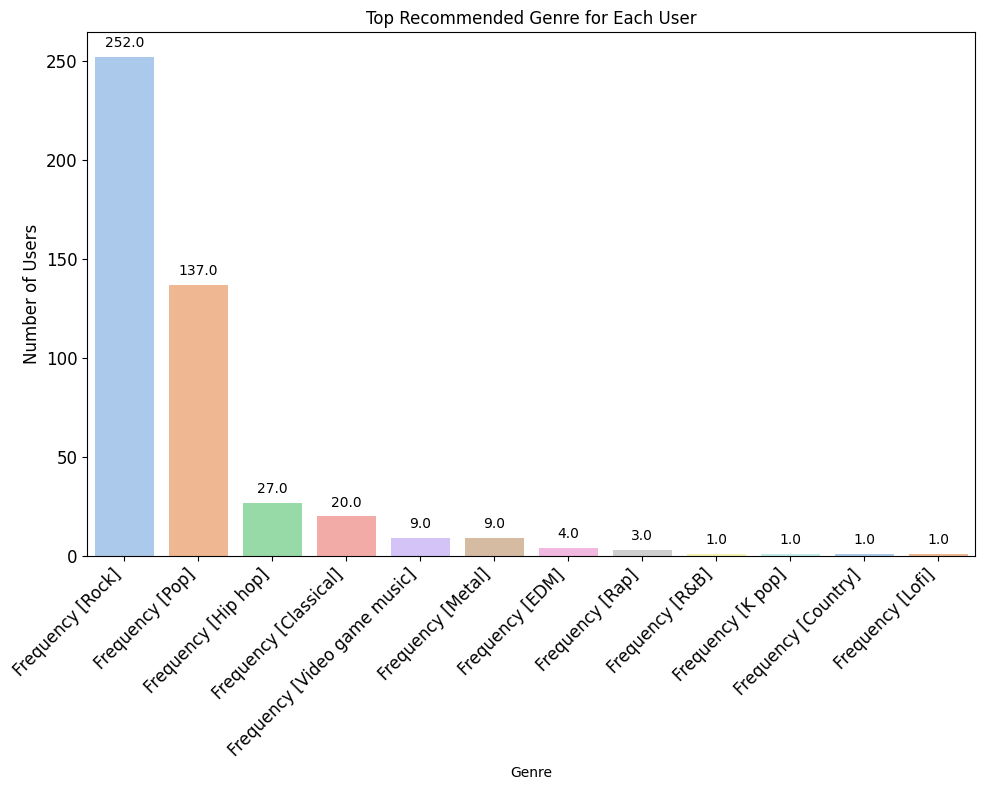

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# bar chart
plt.figure(figsize=(10, 8))
pastel_palette = sns.color_palette("pastel", n_colors=len(result['user_id'].unique()))

plot = sns.countplot(data=result, x='genre', palette=pastel_palette, order=result['genre'].value_counts().index)

plt.title('Top Recommended Genre for Each User')
plt.xlabel('Genre')
plt.ylabel('Number of Users', fontsize=12)

plt.xticks(rotation=45, ha='right', fontsize = 12)
plt.yticks(fontsize = 12)



for p in plot.patches:
    plot.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points',
                fontsize=10, color='black')


plt.tight_layout()
plt.show()

##Finding Bottom Recommended items based on rating Scores

In [32]:
idx = recommender_output_dataframe.groupby(['user_id'])['score'].idxmin()
result = recommender_output_dataframe.loc[idx, ['user_id', 'genre', 'score']]
result

,user_id,genre,score
10,1,Frequency [Metal],0.278114
17,2,Frequency [Country],0.248601
36,3,Frequency [Gospel],0.161244
55,4,Frequency [K pop],0.178321
68,5,Frequency [Gospel],0.217986
...,...,...,...
7364,611,Frequency [Gospel],0.201647
7380,612,Frequency [Gospel],0.196503
7396,613,Frequency [Gospel],0.213956
7412,614,Frequency [Gospel],0.176830


<ipython-input-34-e4aedaca9058>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.countplot(data=result, x='genre', palette=pastel_palette, order=result['genre'].value_counts().index)
<ipython-input-34-e4aedaca9058>:8: UserWarning: The palette list has more values (465) than needed (9), which may not be intended.
  plot = sns.countplot(data=result, x='genre', palette=pastel_palette, order=result['genre'].value_counts().index)


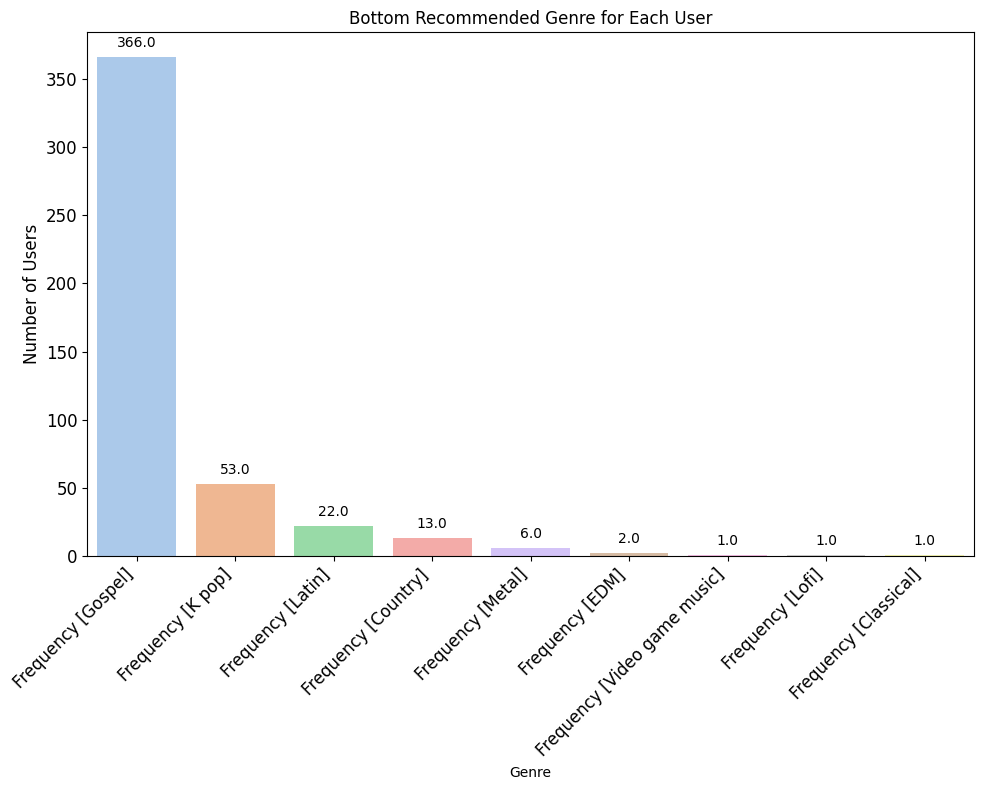

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# bar chart
plt.figure(figsize=(10, 8))
pastel_palette = sns.color_palette("pastel", n_colors=len(result['user_id'].unique()))

plot = sns.countplot(data=result, x='genre', palette=pastel_palette, order=result['genre'].value_counts().index)

plt.title('Bottom Recommended Genre for Each User')
plt.xlabel('Genre')
plt.ylabel('Number of Users', fontsize=12)

plt.xticks(rotation=45, ha='right', fontsize = 12)
plt.yticks(fontsize = 12)



for p in plot.patches:
    plot.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points',
                fontsize=10, color='black')


plt.tight_layout()
plt.show()